In [19]:
import pandas as pd
from datasets import load_dataset
dataset = load_dataset("ag_news")

In [20]:
train_df = dataset['train'].to_pandas()

test_df = dataset['test'].to_pandas()

df = pd.concat([train_df, test_df])
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [21]:
# ['World', 'Sports', 'Business', 'Sci/Tech']

In [22]:
df.shape

(127600, 2)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    127600 non-null  object
 1   label   127600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [24]:
df.isnull().sum()

,0
text,0
label,0


In [25]:
df['label'].value_counts()

,count
label,
2,31900
3,31900
1,31900
0,31900


In [26]:
# Когда работаешь с LLM,
#тексты нужно оставлять максимально приближенными к оригиналу — в этом сила трансформеров: они сами поймут контекст,
#грамматику и даже "шум". Поэтому не удалили стоп слова, не делали стемминг и прочее.
df['text'] = df['text'].astype(str)

In [27]:
import re

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

In [28]:
from sklearn.model_selection import train_test_split

texts = df["text"].tolist()
labels = df["label"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [29]:
from transformers import AutoTokenizer

MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [30]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [31]:
import torch

print("GPU доступен:", torch.cuda.is_available())
print("Устройство модели:", model.device)

GPU доступен: True
Устройство модели: cuda:0


In [33]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.185000,0.156143
2,0.083100,0.154336


TrainOutput(global_step=3190, training_loss=0.1657412273383066, metrics={'train_runtime': 1475.5065, 'train_samples_per_second': 138.366, 'train_steps_per_second': 2.162, 'total_flos': 1.342942941609984e+16, 'train_loss': 0.1657412273383066, 'epoch': 2.0})

In [34]:
import numpy as np

predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

Accuracy: 0.9517633228840126
              precision    recall  f1-score   support

       World       0.97      0.95      0.96      6380
      Sports       0.99      0.99      0.99      6380
    Business       0.93      0.92      0.93      6380
    Sci/Tech       0.92      0.94      0.93      6380

    accuracy                           0.95     25520
   macro avg       0.95      0.95      0.95     25520
weighted avg       0.95      0.95      0.95     25520



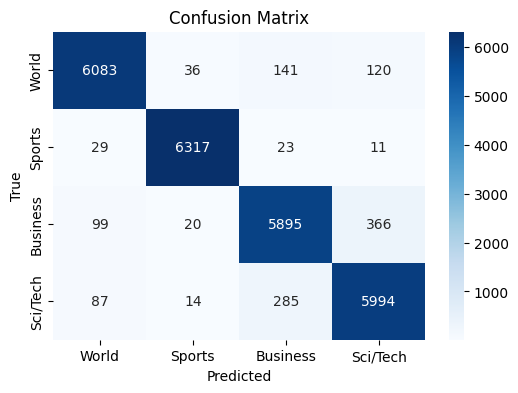

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

print(classification_report(y_true, y_pred, target_names=dataset['train'].features['label'].names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [36]:
from transformers import AutoTokenizer

# BERT или RoBERTa
MODEL_NAME2 = "roberta-base"

tokenizer2 = AutoTokenizer.from_pretrained(MODEL_NAME2)

train_encodings2 = tokenizer2(train_texts, truncation=True, padding=True, max_length=128)
val_encodings2 = tokenizer2(val_texts, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
train_dataset2 = NewsDataset(train_encodings2, train_labels)
val_dataset2 = NewsDataset(val_encodings2, val_labels)

In [38]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME2, num_labels=4)

training_args2 = TrainingArguments(
    output_dir="./results2",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=train_dataset2,
    eval_dataset=val_dataset2,
)

trainer2.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.188500,0.160181


Epoch,Training Loss,Validation Loss
1,0.188500,0.160181
2,0.101200,0.149087


TrainOutput(global_step=3190, training_loss=0.18299514952124474, metrics={'train_runtime': 1634.3111, 'train_samples_per_second': 124.921, 'train_steps_per_second': 1.952, 'total_flos': 1.342942941609984e+16, 'train_loss': 0.18299514952124474, 'epoch': 2.0})

In [43]:
import numpy as np

predictions22 = trainer2.predict(val_dataset2)
y_pred2 = np.argmax(predictions22.predictions, axis=1)
y_true2 = predictions22.label_ids

Accuracy: 0.9510579937304076
              precision    recall  f1-score   support

       World       0.96      0.95      0.96      6380
      Sports       0.99      0.99      0.99      6380
    Business       0.93      0.92      0.93      6380
    Sci/Tech       0.92      0.94      0.93      6380

    accuracy                           0.95     25520
   macro avg       0.95      0.95      0.95     25520
weighted avg       0.95      0.95      0.95     25520



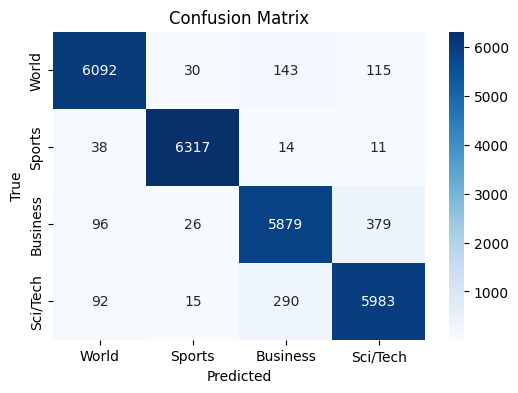

In [44]:
# Accuracy
acc2 = accuracy_score(y_true2, y_pred2)
print("Accuracy:", acc2)

print(classification_report(y_true2, y_pred2, target_names=dataset['train'].features['label'].names))

# Confusion Matrix
cm2 = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()